In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob

In [2]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [3]:
#Discrete Fourier Transform 

def fft(x):
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(x))))

In [4]:
flag_files = sorted(glob.glob('H1C_Flags/*.flags.h5'))
data_file = "./prisim_hera_test/2020-12-07-21-06-34/simdata/all-simvis-noiseless.uvh5"
model_file = "./prisim_hera_test/2020-12-07-19-10-20/simdata/all-simvis-noiseless.uvh5"

In [5]:

for day,flag_file in enumerate(flag_files):
    #Opening Data/Flags
    hd_data = HERAData(data_file)    
    hd_model = HERAData(model_file) 
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
                 times = flags.time_array[3000:4000])
    d_data, d_flags, d_nsamples = hd_data.read()
    m_data, m_flags, m_nsamples = hd_model.read()
    for bl in d_data:
        d_flags[bl] = flags.flag_array.squeeze()
        m_flags[bl] = flags.flag_array.squeeze()
    hd_data.update(flags=d_flags)
    hd_model.update(flags=m_flags)
    hd_data.x_orientation='north'
    hd_model.x_orientation='north'
    hd_data.write_uvh5(f"data_{day}.uvh5", clobber=True)
    hd_model.write_uvh5(f"model_{day}.uvh5", clobber=True)
    del d_data,d_flags,d_nsamples,m_data,m_flags,m_nsamples,hd_data,hd_model
    #Calculate Gains/Smooth
    redcal.redcal_run(input_data=f'data_{day}.uvh5', clobber=True, solar_horizon=90, verbose=True)
    abscal.post_redcal_abscal_run(data_file = f'data_{day}.uvh5', redcal_file = f'data_{day}.omni.calfits',
                                  model_files = [f"model_{day}.uvh5"], clobber=True, data_solar_horizon=90,
                                  model_solar_horizon=90)
    cs = smooth_cal.CalibrationSmoother(calfits_list=[f'data_{day}.abs.calfits'])
    cs.time_freq_2D_filter(time_scale=21600)
    cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))
    #Apply Smooth Gains
    apply_cal.apply_cal(data_infilename=f'data_{day}.uvh5', data_outfilename=f'data_{day}_smoothcal.uvh5',
                        new_calibration=f'data_{day}.smooth_abs.calfits')
    #Fourier-Filter
    vc = vis_clean.VisClean(f"data_{day}_smoothcal.uvh5")
    vc.read()
    vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
    vc.write_filtered_data(filled_outfilename=f'data_{day}_filtered.uvh5',clobber=True)

antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_0.first.calfits
Now saving omnical gains to data_0.omni.calfits
Now saving omnical visibilities to data_0.omni_vis.uvh5
Now saving redcal metadata to  data_0.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_0.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.0041684032021316
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.03484421029005745
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0047730232554013905
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.002386511627883466
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0011932558139641641
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_0_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_1.first.calfits
Now saving omnical gains to data_1.omni.calfits
Now saving omnical visibilities to data_1.omni_vis.uvh5
Now saving redcal metadata to  data_1.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_1.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.9926629922300325
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.028450011444495823
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0013911355817797025
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006955677908946881
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0003477838954469863
...configuring global_phase_slope_logcal for t

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_1_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_2.first.calfits
Now saving omnical gains to data_2.omni.calfits
Now saving omnical visibilities to data_2.omni_vis.uvh5
Now saving redcal metadata to  data_2.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_2.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.6722978678425044
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.020001534130996514
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0020315847273665415
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0010157923636963523
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00050789618185151
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_2_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_3.first.calfits
Now saving omnical gains to data_3.omni.calfits
Now saving omnical visibilities to data_3.omni_vis.uvh5
Now saving redcal metadata to  data_3.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_3.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.102941792870491
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.013554099275573375
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0028357326784731575
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001417866339274956
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0007089331696416874
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_3_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_4.first.calfits
Now saving omnical gains to data_4.omni.calfits
Now saving omnical visibilities to data_4.omni_vis.uvh5
Now saving redcal metadata to  data_4.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_4.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.9919442368013636
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.07085107845777065
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0004678045253036934
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0002339022626530726
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00011695113132597455
...configuring global_phase_slope_logcal for t

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_4_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_5.first.calfits
Now saving omnical gains to data_5.omni.calfits
Now saving omnical visibilities to data_5.omni_vis.uvh5
Now saving redcal metadata to  data_5.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_5.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.7814208750633838
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.018997286136913205
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006473170166230219
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00032365850831207987
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00016182925415666438
...configuring global_phase_slope_logcal for

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_5_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_6.first.calfits
Now saving omnical gains to data_6.omni.calfits
Now saving omnical visibilities to data_6.omni_vis.uvh5
Now saving redcal metadata to  data_6.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_6.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.328513590240844
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003972297928885126
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0019861489645472794
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0009930744822868385
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0004965372411462115
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_6_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_7.first.calfits
Now saving omnical gains to data_7.omni.calfits
Now saving omnical visibilities to data_7.omni_vis.uvh5
Now saving redcal metadata to  data_7.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_7.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1736741975230194
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.8586257395119902e-05
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 9.293128697786468e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 4.6465643477167195e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.3232821746220913e-06
...configuring global_phase_slope_logcal f

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_7_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_8.first.calfits
Now saving omnical gains to data_8.omni.calfits
Now saving omnical visibilities to data_8.omni_vis.uvh5
Now saving redcal metadata to  data_8.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_8.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.8619624592971746
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.02595453000126754
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0014285789078383082
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0007142894539238721
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0003571447269613704
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_8_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_9.first.calfits
Now saving omnical gains to data_9.omni.calfits
Now saving omnical visibilities to data_9.omni_vis.uvh5
Now saving redcal metadata to  data_9.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_9.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.328346815401511
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.011198407009657456
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.005426100487100095
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.002713050243819471
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0013565251219437363
...configuring global_phase_slope_logcal for the 

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_9_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_10.first.calfits
Now saving omnical gains to data_10.omni.calfits
Now saving omnical visibilities to data_10.omni_vis.uvh5
Now saving redcal metadata to  data_10.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_10.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.6163083234326807
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.021947299744371148
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.008118378917896796
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.004059189459846492
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00202959473003521
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_10_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_11.first.calfits
Now saving omnical gains to data_11.omni.calfits
Now saving omnical visibilities to data_11.omni_vis.uvh5
Now saving redcal metadata to  data_11.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_11.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.489315672888425
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.08375297155651852
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003563582498606403
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001781791249378061
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008908956246995714
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_11_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_12.first.calfits
Now saving omnical gains to data_12.omni.calfits
Now saving omnical visibilities to data_12.omni_vis.uvh5
Now saving redcal metadata to  data_12.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_12.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.2182003157145718
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0348093252865097
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.007384103487581903
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0036920517444661944
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001846025872317216
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_12_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_13.first.calfits
Now saving omnical gains to data_13.omni.calfits
Now saving omnical visibilities to data_13.omni_vis.uvh5
Now saving redcal metadata to  data_13.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_13.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1666838485247073
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.020797513792433782
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006669410655470225
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00033347053277358056
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00016673526638789663
...configuring global_phase_slope_logcal for

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_13_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_14.first.calfits
Now saving omnical gains to data_14.omni.calfits
Now saving omnical visibilities to data_14.omni_vis.uvh5
Now saving redcal metadata to  data_14.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_14.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1660774948013026
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003360006455006441
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0016800032275669672
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008400016137908517
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.000420000806897744
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_14_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_15.first.calfits
Now saving omnical gains to data_15.omni.calfits
Now saving omnical visibilities to data_15.omni_vis.uvh5
Now saving redcal metadata to  data_15.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_15.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.7793932604365104
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.03763300095374983
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0026729071673416405
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001336453583701443
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006682267918551617
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_15_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_16.first.calfits
Now saving omnical gains to data_16.omni.calfits
Now saving omnical visibilities to data_16.omni_vis.uvh5
Now saving redcal metadata to  data_16.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_16.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


overflow encountered in square
invalid value encountered in reduce


...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.65563115408242
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.010067679613797459
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0017483993332335485
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008741996666253328
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00043709983331436265
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_16_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_17.first.calfits
Now saving omnical gains to data_17.omni.calfits
Now saving omnical visibilities to data_17.omni_vis.uvh5
Now saving redcal metadata to  data_17.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_17.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.3891894295434564
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1958278275514463e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 5.979139134454718e-07
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 47.16929254241395
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 17.024206816578456
...configuring global_phase_slope_logcal for the li

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_17_filtered.uvh5


In [24]:
# hc = io.HERACal("data_0.abs.calfits")
# hc2 = io.HERACal("data_0.smooth_abs.calfits")
# gains, flags, _, _ = hc.read()
# gains2, flags2, i2, a2 = hc2.read()


In [28]:
# plt.plot(data.freqs/1e6, gains[(0,'Jnn')][300]/~flags[(0,'Jnn')][300], label='Gains')
# plt.plot(data.freqs/1e6, gains2[(0,'Jnn')][300]/~flags[(0,'Jnn')][300], label='Smoothed Gains')
# plt.ylabel('Magnitude')
# plt.xlabel('Frequency [MHz]')
# plt.legend()

In [29]:
# hd_data = HERAData(data_file)    
# hd_model = HERAData(model_file) 
# flags = UVFlag(flag_file)
# flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
#                  times = flags.time_array[3000:4000])
# d_data, d_flags, d_nsamples = hd_data.read()
# m_data, m_flags, m_nsamples = hd_model.read()
# print(d_data.keys())

In [103]:
#Average Before Filter
for day in range(18):
    cfile = f"data_{day}_smoothcal.uvh5"
    hd = HERAData(cfile)
    data_t,flags_t,nsamples_t = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
        nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
            flags_avg[bl] = flags_avg[bl] & flags_t[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
    data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg.uvh5', clobber=True)

invalid value encountered in true_divide


File exists; clobbering


In [104]:
vc = vis_clean.VisClean(f"data_avg.uvh5")
vc.read()
vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
vc.write_filtered_data(filled_outfilename='data_avg_beforefiltered.uvh5',clobber=True)

File exists; clobbering
...writing to data_avg_beforefiltered.uvh5


In [94]:
model_avg, res_avg, info_avg = dspec.fourier_filter(x=data.freqs, data=data[(0,1,'nn')],
                                           wgts=~(flags_avg[(0,1,'nn')]), filter_centers=[0], filter_half_widths=[300e-9],
                                          mode= 'dpss_leastsq',suppression_factors=[1e-9])

In [66]:
hd = HERAData("data_avg_beforefiltered.uvh5")
data, flags, nsamples = hd.read()
bh = dspec.gen_window('bh',409)
jul = 24*3600             #julian date to seconds
interpolated_times = (hd.times -hd.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
ext = delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min()

# plt.plot(delay_blh*1e+9,fft(bh*(data[(0,1,'nn')]))[10]*(data.freqs[1]-data.freqs[0]))
# #plt.plot(delay_blh*1e+9,fft(bh*(res_avg+model_avg))[10]*(data.freqs[1]-data.freqs[0]))
# # plt.plot(data.freqs/1e+6,abs(data[(0,1,'nn')][10]*(data.freqs[1]-data.freqs[0])))
# plt.xlabel('Delay [ns]')
# plt.ylabel('Visibility [Jy*Hz]')
# plt.yscale('log')

In [40]:
#Average After Filter
for day in range(18):
    ffile = f'data_{day}_filtered.uvh5'
    hd = HERAData(ffile)
    data_t,flags_t,nsmaples_t = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
        nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
            flags_avg[bl] = flags_avg[bl] & flags_t[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg_afterfiltered.uvh5', clobber=True)


invalid value encountered in true_divide


In [25]:
# glob.glob('*smooth*')

['HERA_FTsmoothedgains_B.pdf',
 'data_A_smoothcal.uvh5',
 'Day_A_smoothcal.uvh5',
 'HERA_FTsmoothedgains_A.pdf',
 'data_0.smooth_abs.calfits']

In [24]:
# cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))

Mean of empty slice


In [79]:
# rms_avg_before = np.sqrt(np.mean(np.abs(data[(0,1,'nn')]) ** 2, axis=0))

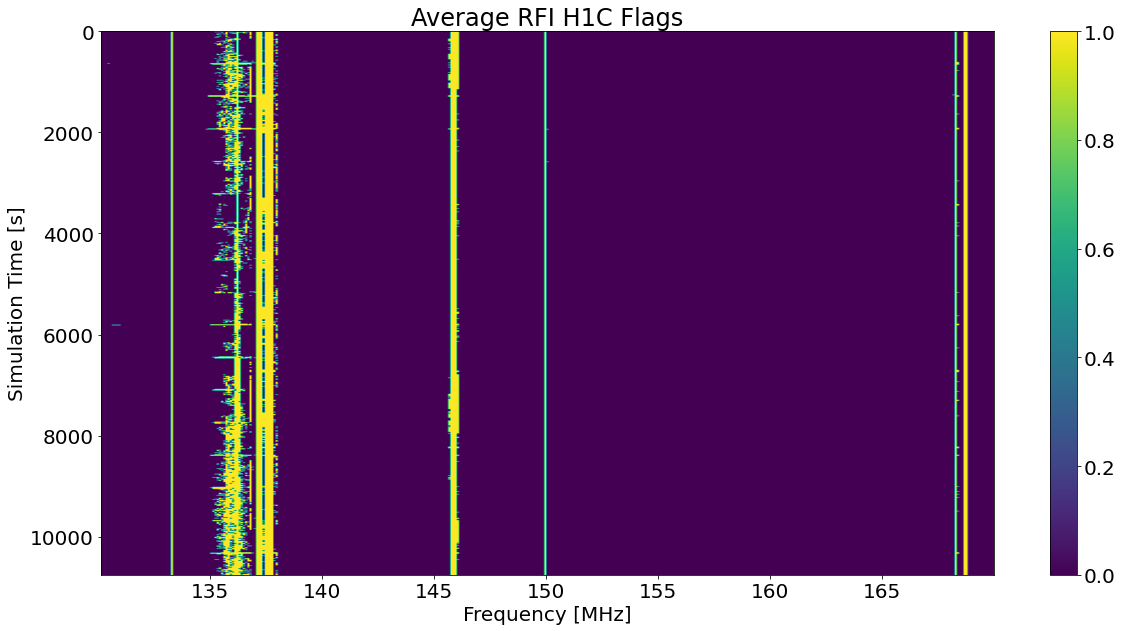

In [89]:
# extents = hd.freqs[0]/1e6, hd.freqs[-1]/1e6,  interpolated_times.max(), interpolated_times.min()
# plt.imshow(flags_avg[(0,1,'nn')],extent=extents, aspect='auto')
# plt.title('Average RFI H1C Flags')
# plt.xlabel('Frequency [MHz]')
# plt.ylabel('Simulation Time [s]')
# plt.colorbar()
# #plt.savefig('Average_RFI.pdf')
# # plt.ylim(8000,7000)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Antenna 0, Snapshot 10')

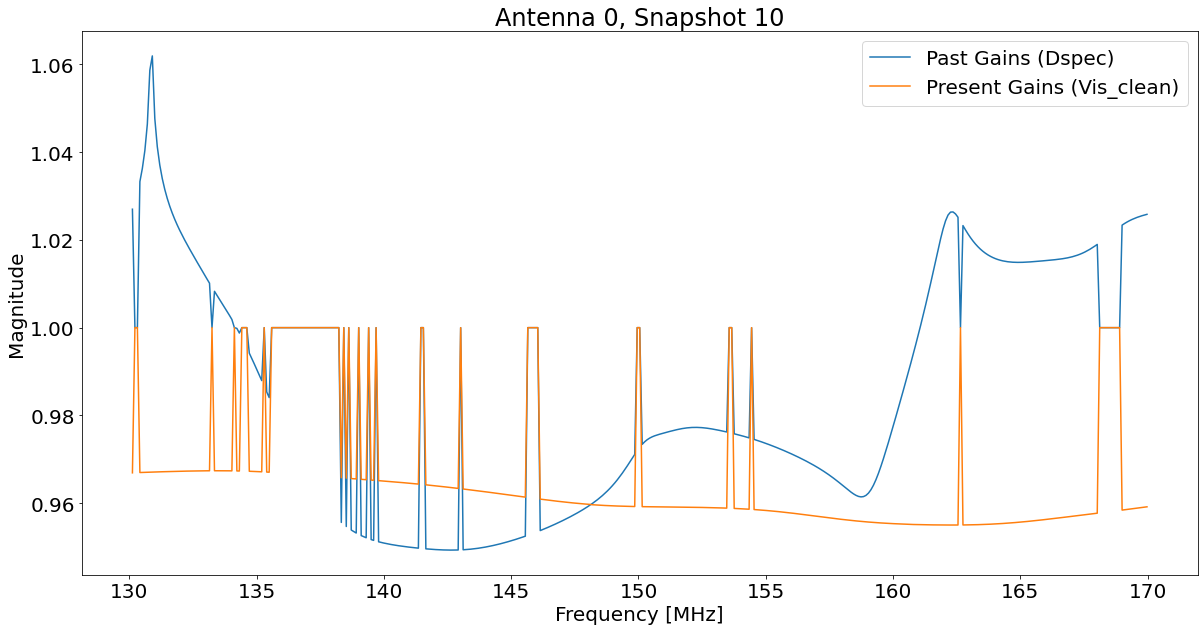

In [127]:
with open('GAINS/gains_1.pickle', 'rb') as handle:
    gains_1 = pickle.load(handle)
    
hc = io.HERACal("data_0.abs.calfits")
gains, flags, _, _ = hc.read()


plt.plot(data.freqs/1e6, gains_1[(0,'Jxx')][10], label="Past Gains (Dspec)")
plt.plot(data.freqs/1e6, gains[(0,'Jnn')][10], label='Present Gains (Vis_clean)')
plt.ylabel('Magnitude')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.title('Antenna 0, Snapshot 10')

In [8]:
for day,flag_file in enumerate(flag_files[0:1]):
    #Opening Data/Flags
    hd_data = HERAData(data_file)    
    hd_model = HERAData(model_file) 
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
                 times = flags.time_array[3000:4000])
    d_data, d_flags, d_nsamples = hd_data.read()
    m_data, m_flags, m_nsamples = hd_model.read()
    weights = DataContainer({})
    for bl in d_data:
        d_flags[bl] = flags.flag_array.squeeze()
        m_flags[bl] = flags.flag_array.squeeze()
        weights[bl] = (~(d_flags[bl].astype('bool'))).astype(float)
    redcal_flags = {}
    for key in m_flags:
        antkey_xx = (key[0], 'Jxx')
        redcal_flags[antkey_xx] = m_flags[key]
    hd_data.update(flags=d_flags)
    hd_model.update(flags=m_flags)
    hd_data.x_orientation='north'
    hd_model.x_orientation='north'
    hd_data.write_uvh5(f"data_{day}_test.uvh5", clobber=True)
    hd_model.write_uvh5(f"model_{day}_test.uvh5", clobber=True)
    #Calculate Gains/Smooth
    gains = abscal.post_redcal_abscal(copy.deepcopy(d_data),copy.deepcopy(m_data), weights, redcal_flags)
    del d_data,d_flags,d_nsamples,m_data,m_flags,m_nsamples,hd_data,hd_model

File exists; clobbering
File exists; clobbering
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.8971372831593805
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.8331503390299139
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.40153955885685183
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.1863279535564881
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.08646161706980056
...configuring global_phase_slope_logcal for the linfit

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Calibration Solutions , Antenna 0, Snapshot 10')

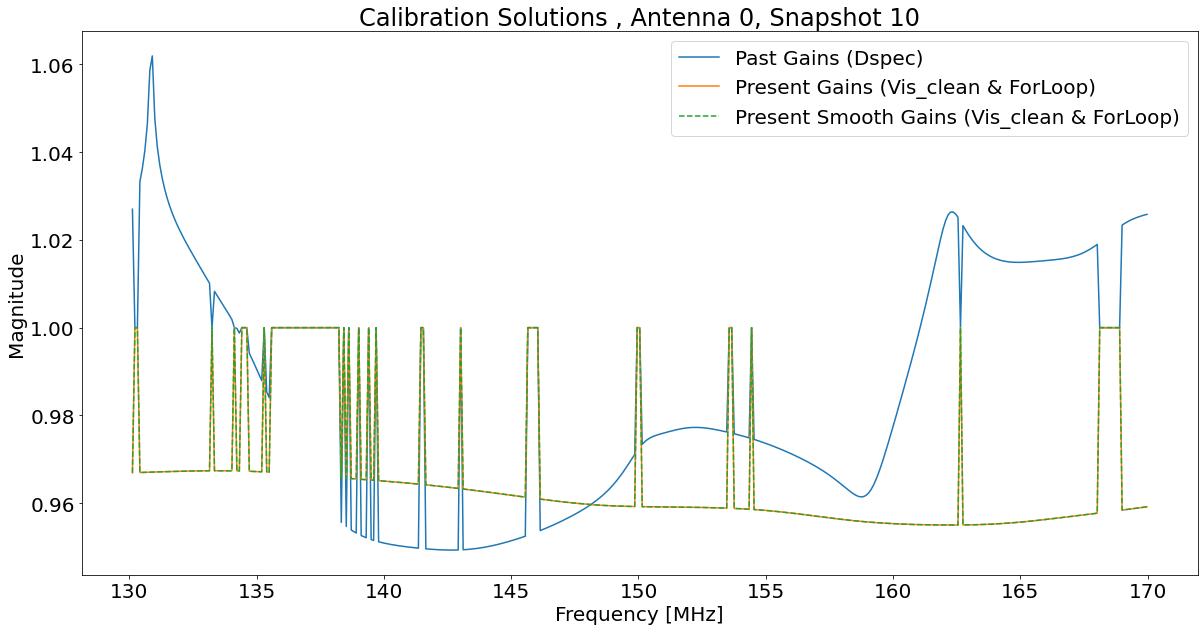

In [5]:
hd = HERAData("data_avg_beforefiltered.uvh5")
data, flags, nsamples = hd.read()
bh = dspec.gen_window('bh',409)
jul = 24*3600             #julian date to seconds
interpolated_times = (hd.times -hd.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
ext = delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min()


with open('GAINS/gains_1.pickle', 'rb') as handle:
    gains_past = pickle.load(handle)  
hc = io.HERACal("data_0.abs.calfits")
gains_present, flags, _, _ = hc.read()
hcs = io.HERACal("data_0.smooth_abs.calfits")
gains_smooth_present, flags_smooth, _, _ = hc.read()

plt.plot(data.freqs/1e6, gains_past[(0,'Jxx')][10], label="Past Gains (Dspec)")
plt.plot(data.freqs/1e6, gains_present[(0,'Jnn')][10], label='Present Gains (Vis_clean & ForLoop)')
plt.plot(data.freqs/1e6, gains_smooth_present[(0,'Jnn')][10],ls='--', label='Present Smooth Gains (Vis_clean & ForLoop)')
# plt.plot(data.freqs/1e6, gains[(0,'Jxx')][10], label='Test Gains (Dspec & ForLoop)')
plt.ylabel('Magnitude')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.title('Calibration Solutions , Antenna 0, Snapshot 10')

In [14]:
lambda_obs = 2      #150MHz ---> 2m
lambda_emit = 0.21      #0.21m 
z = (lambda_obs - lambda_emit)/lambda_emit  #z=8.5
X2Y = 540*(((1+z)/10)**(0.9))
B = data.freqs.max()-data.freqs.min()  
d = 14           #14m (diameter of dish)
theta = (1.22*(lambda_obs/d))**2
Omega = np.pi*theta**2
k_b = 1.38e-23  #J/K
Power_Transformation = ((X2Y)/(Omega*B))*(((2*k_b)/(lambda_obs**2))**-2)*(1e-52)



# for day in range(18):
#     pfile = f'data_{day}_smoothcal.uvh5'
#     hdp = HERAData(pfile)
#     data_p,flags_p,nsamples_p = hdp.read()
#     for bl in data_p:
#         data_p[bl] = fft(bh*data_p[bl])
#         data_p[bl] = (np.abs(data_p[bl])**2)*Power_Transformation
#     hdp.update(data=data_p, flags=flags_p, nsamples=nsamples_p)
#     hdp.write_uvh5(f'data_{day}_power.uvh5', clobber=True)
    

Text(0, 0.5, 'Power [h^-3 * Mpc^3 * mK^2]')

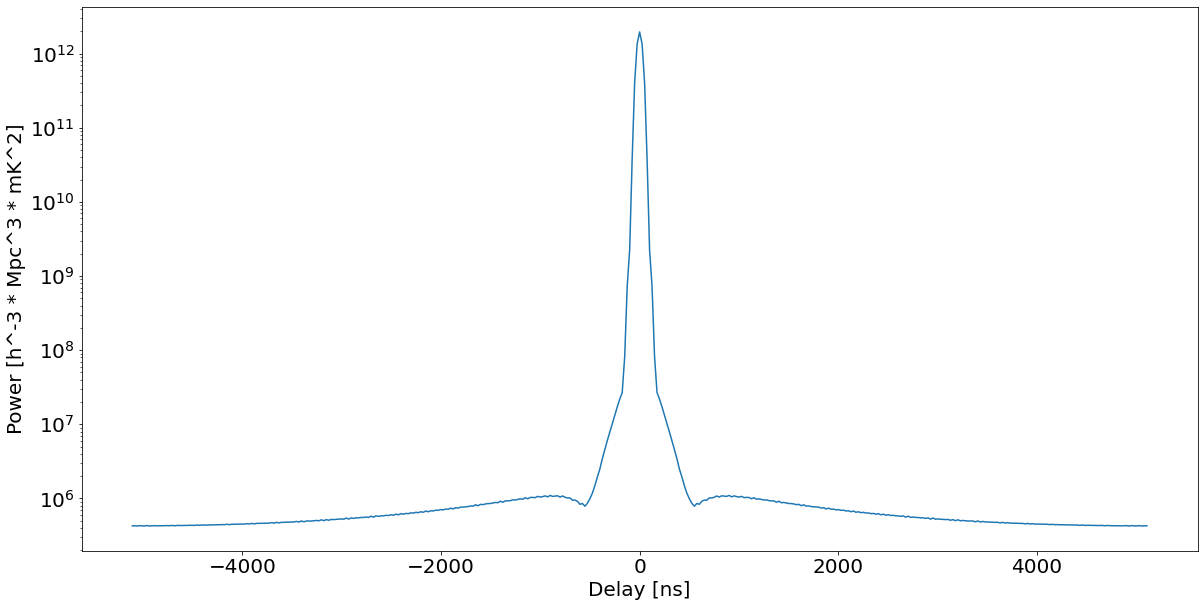

In [19]:
pfile = 'data_avg_power_afterfilter_filter.uvh5'
hdp = HERAData(pfile)
data_p,flags_p,nsamples_p = hdp.read()
plt.plot(delay_blh*1e+9, (data_p[(0,1,'nn')][0]*1e6)*((data.freqs[1]-data.freqs[0])**2))
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

In [28]:
#Average Before Filter (power)
for day in range(18):
    pfile = f"data_{day}_power.uvh5"
    hd = HERAData(pfile)
    data_p,flags_p,nsamples_p = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_p[bl]*nsamples_p[bl]*(~flags_p[bl]) for bl in data_p})
        flags_avg =DataContainer({bl:flags_p[bl] for bl in data_p})
        nsamples_avg = DataContainer({bl:nsamples_p[bl]*(~flags_p[bl]) for bl in data_p})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_p[bl]*nsamples_p[bl]*(~flags_p[bl])
            flags_avg[bl] = flags_avg[bl] & flags_p[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_p[bl]*(~flags_p[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
    data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg_power_beforefilter.uvh5', clobber=True)

invalid value encountered in true_divide


In [30]:
vca = vis_clean.VisClean('data_avg_power_beforefilter.uvh5')
vca.read()
vca.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
vca.write_filtered_data(filled_outfilename='data_avg_power_beforefiltered_filtered.uvh5',clobber=True)

...writing to data_avg_power_beforefiltered_filtered.uvh5


In [32]:
#Average After Filter (power)
for day in range(18):
    pfile = f'data_{day}_filtered.uvh5'
    hd = HERAData(pfile)
    data_p,flags_p,nsmaples_p = hd.read()
    for bl in data_p:
        data_p[bl] = (np.abs(data_p[bl])**2)*Power_Transformation
    if day==0:
        data_avg=DataContainer({bl:data_p[bl]*nsamples_p[bl]*(~flags_p[bl]) for bl in data_p})
        flags_avg =DataContainer({bl:flags_p[bl] for bl in data_p})
        nsamples_avg = DataContainer({bl:nsamples_p[bl]*(~flags_p[bl]) for bl in data_p})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_p[bl]*nsamples_p[bl]*(~flags_p[bl])
            flags_avg[bl] = flags_avg[bl] & flags_p[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_p[bl]*(~flags_p[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg_power_afterfilter_filter.uvh5', clobber=True)


invalid value encountered in true_divide


In [6]:
a_file = 'data_avg_power_afterfilter_filter.uvh5'
ha = HERAData(a_file)
data_a, flags_a, bsamples_a = ha.read()
avg_afterfilter = (np.mean(np.abs(data_a[(0,1,'nn')])** 2, axis=0))

b_file = 'data_avg_power_beforefiltered_filtered.uvh5'
hb = HERAData(b_file)
data_b, flags_b, bsamples_b = hb.read()
avg_beforefilter = (np.mean(np.abs(data_b[(0,1,'nn')])** 2, axis=0))

In [22]:
token = open('ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3','r')
linestoken=token.readlines()
tokens_column_number = 1
delta_21=[]
for x in linestoken:
    delta_21.append(x.split()[tokens_column_number])
token.close()

In [57]:
omega = 0.27
Y = 17*((1+z/10)**0.5)*(omega/0.15)**(-0.5)
K = (2*np.pi*delay_blh) / Y 
P = (2*(np.pi**2))/K**3

power_21 = delta_21 * P
plt.plot(delay_blh*1e9, fft(bh*power_21*((data.freqs[1]-data.freqs[0])**2)))
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

divide by zero encountered in true_divide


TypeError: unsupported operand type(s) for *: 'map' and 'float'

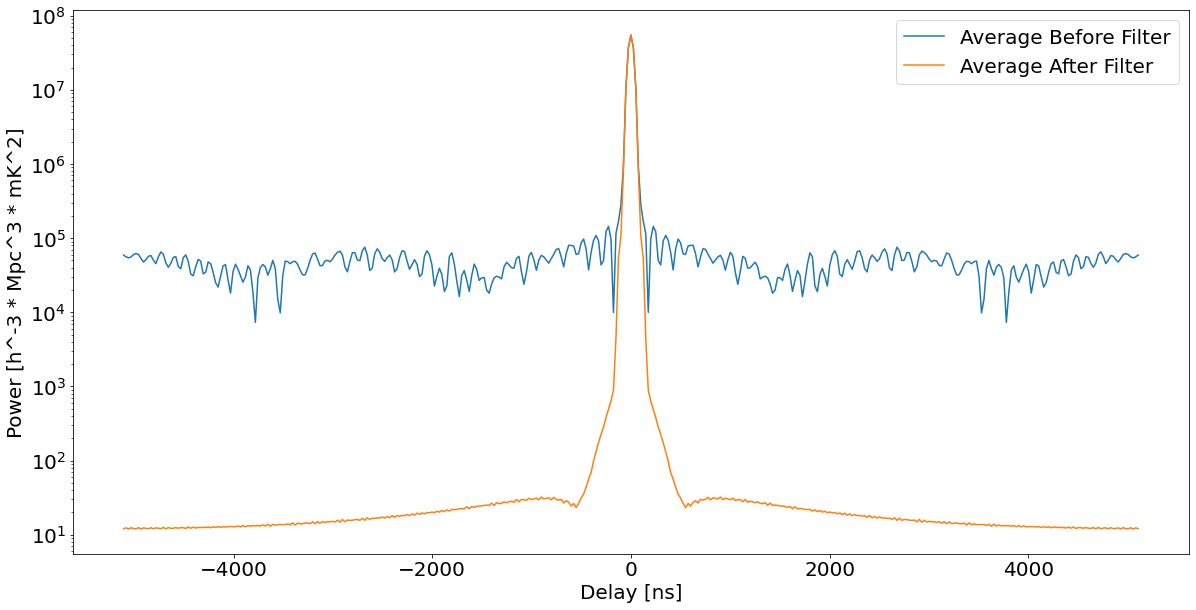

In [7]:
plt.plot(delay_blh*1e+9, (fft(bh*(avg_beforefilter)*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average Before Filter')
plt.plot(delay_blh*1e+9, (fft(bh*(avg_afterfilter)*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average After Filter')
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')
# plt.hlines(rms_avg_before_delay, -5200,5000)
# plt.hlines(rms_avg_after_delay, -5200,5000)
plt.legend()

In [8]:
a_file = 'data_avg_power_afterfilter_filter.uvh5'
ha = HERAData(a_file)
data_a, flags_a, bsamples_a = ha.read()
avg_afterfilter = np.sqrt((np.mean(np.abs(data_a[(0,1,'nn')])** 2, axis=0)))

b_file = 'data_avg_power_beforefiltered_filtered.uvh5'
hb = HERAData(b_file)
data_b, flags_b, bsamples_b = hb.read()
avg_beforefilter = np.sqrt((np.mean(np.abs(data_b[(0,1,'nn')])** 2, axis=0)))

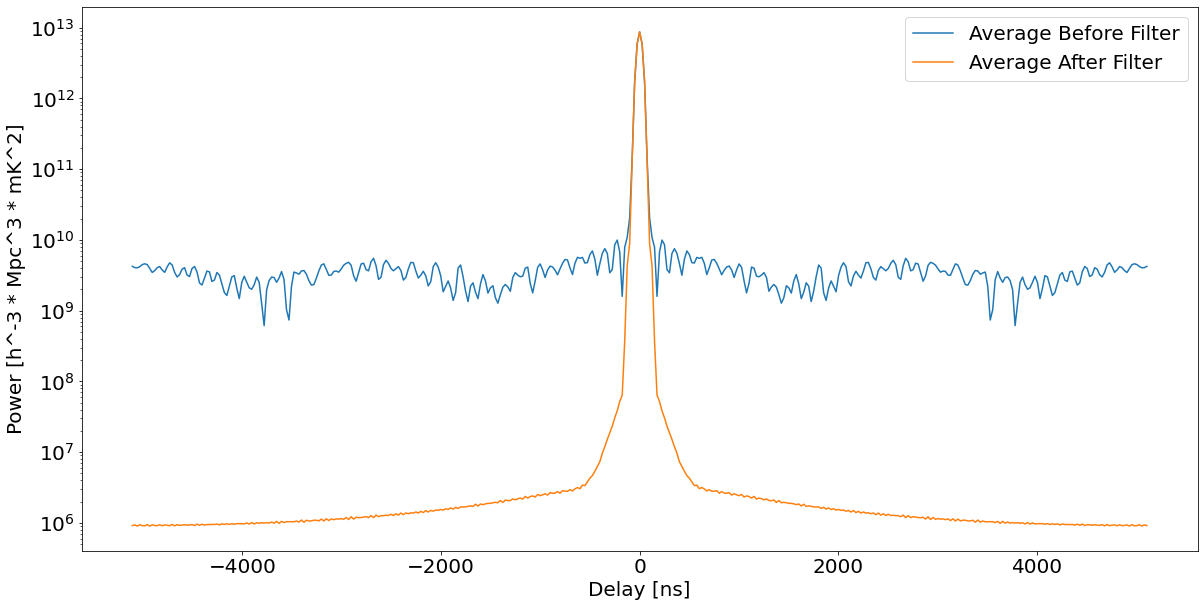

In [9]:
plt.plot(delay_blh*1e+9, (fft(bh*(avg_beforefilter)*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average Before Filter')
plt.plot(delay_blh*1e+9, (fft(bh*(avg_afterfilter)*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average After Filter')
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')
# plt.hlines(rms_avg_before_delay, -5200,5000)
# plt.hlines(rms_avg_after_delay, -5200,5000)
plt.legend()

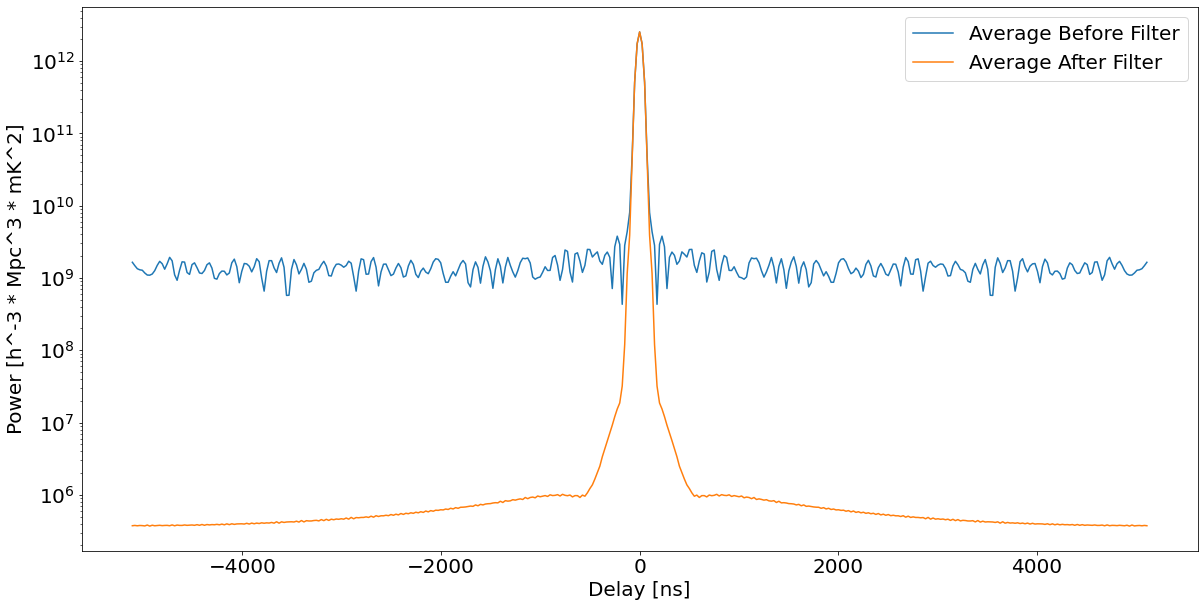

In [74]:
plt.plot(delay_blh*1e+9, (fft(bh*(data_b[(0,1,'nn')][10])*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average Before Filter')
plt.plot(delay_blh*1e+9, (fft(bh*(data_a[(0,1,'nn')][10])*1e6))*((data.freqs[1]-data.freqs[0])**2), label='Average After Filter')
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')
# plt.hlines(rms_avg_before_delay, -5200,5000)
# plt.hlines(rms_avg_after_delay, -5200,5000)
plt.legend()

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


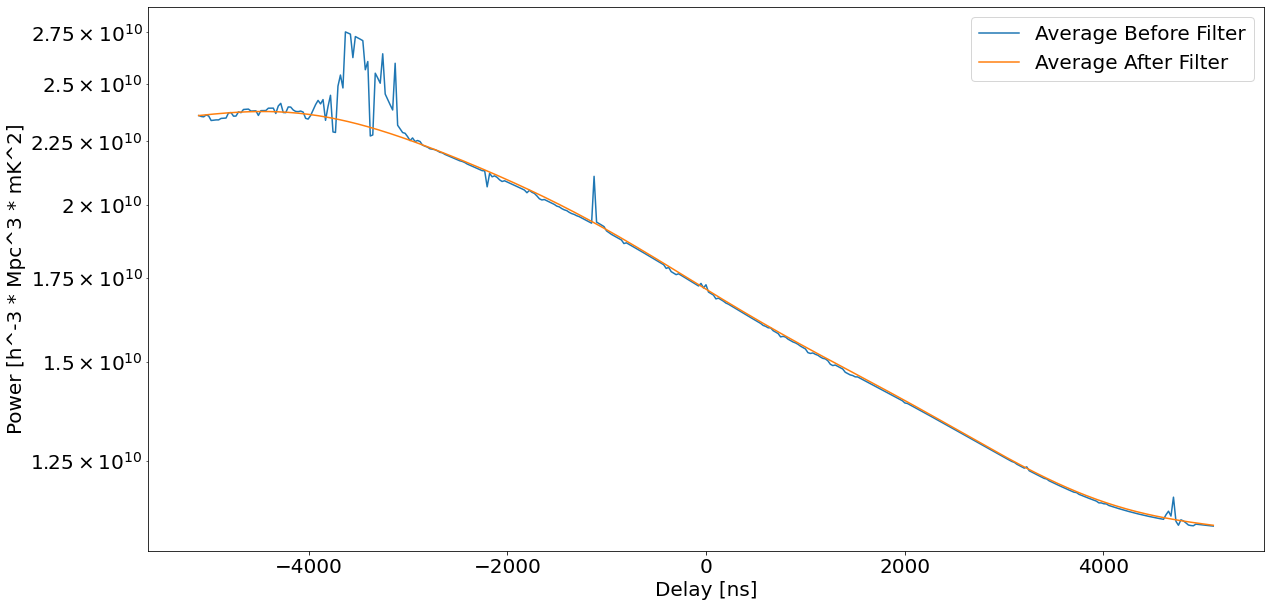

In [10]:
plt.plot(delay_blh*1e+9, (data_b[(0,1,'nn')][10]*1e6)*((data.freqs[1]-data.freqs[0])**2), label='Average Before Filter')
plt.plot(delay_blh*1e+9, (data_a[(0,1,'nn')][10]*1e6)*((data.freqs[1]-data.freqs[0])**2), label='Average After Filter')
plt.yscale('log')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')
# plt.hlines(rms_avg_before_delay, -5200,5000)
# plt.hlines(rms_avg_after_delay, -5200,5000)
plt.legend()

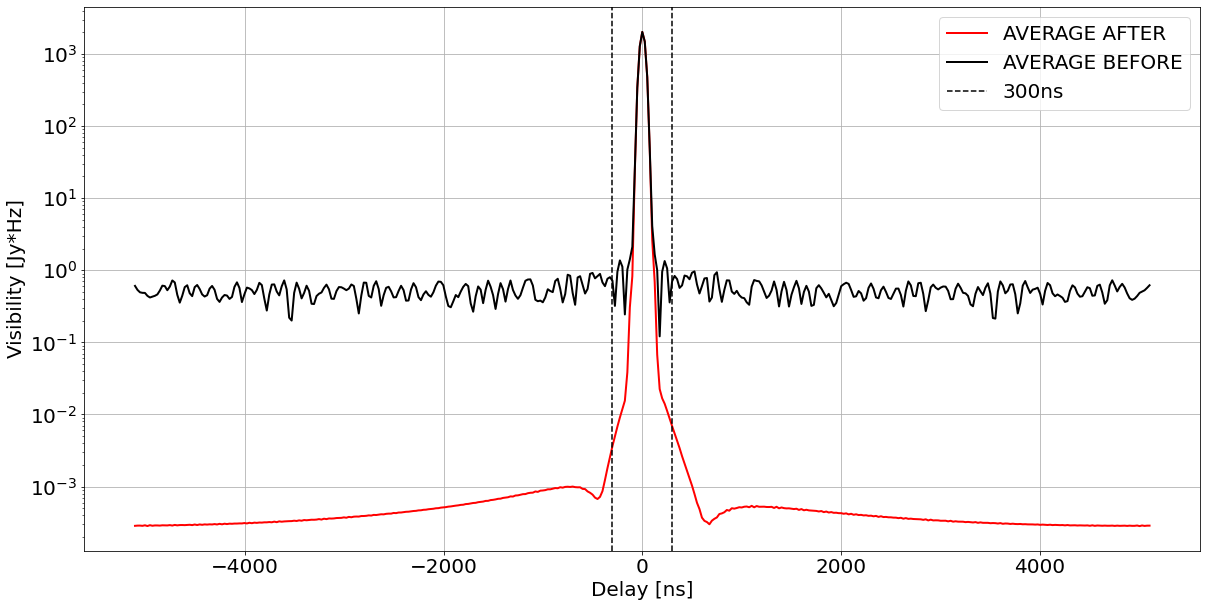

In [79]:
file = 'data_avg_afterfiltered.uvh5'
hd = HERAData(file)
data_after, flags_after, nsamples_after = hd.read()
file = 'data_avg_beforefiltered.uvh5'
hd = HERAData(file)
data_before, flags_before, nsamples_before = hd.read()


plt.plot(delay_blh*1e+9,fft(bh*(data_after[(0,1,'nn')])[10]), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*(data_before[(0,1,'nn')])[10]), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

In [61]:
afile = 'data_avg_afterfiltered.uvh5'
hda = HERAData(afile)
data_after, flags_after, nsamples_after = hda.read()
avg_after = (np.mean(np.abs(data_after[(0,1,'nn')])** 2, axis=0))

bfile = 'data_avg_beforefiltered.uvh5'
hdb = HERAData(bfile)
data_before, flags_before, nsamples_before = hdb.read()
avg_before = (np.mean(np.abs(data_before[(0,1,'nn')])** 2, axis=0))

# plt.plot(data.freqs/1e6, avg_after, label='AVG AFTER')
# plt.plot(data.freqs/1e6, avg_before, label='AVG BEFORE')
# plt.ylabel('Visibility [Jy*Hz]')
# plt.xlabel('Frequency[MHz]')
# plt.yscale('log')
# plt.figure()
# plt.plot(delay_blh*1e+9,fft(bh*avg_after), label='AVERAGE AFTER', color='red', linewidth=2)
# plt.plot(delay_blh*1e+9,fft(bh*avg_before), label='AVERAGE BEFORE', color='black', linewidth=2)
# plt.axvline(300,color='black', linestyle='--', label='300ns')
# plt.axvline(-300,color='black', linestyle='--')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Visibility [Jy*Hz]')

# plt.yscale('log')
# # plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
# plt.grid()
# plt.legend()

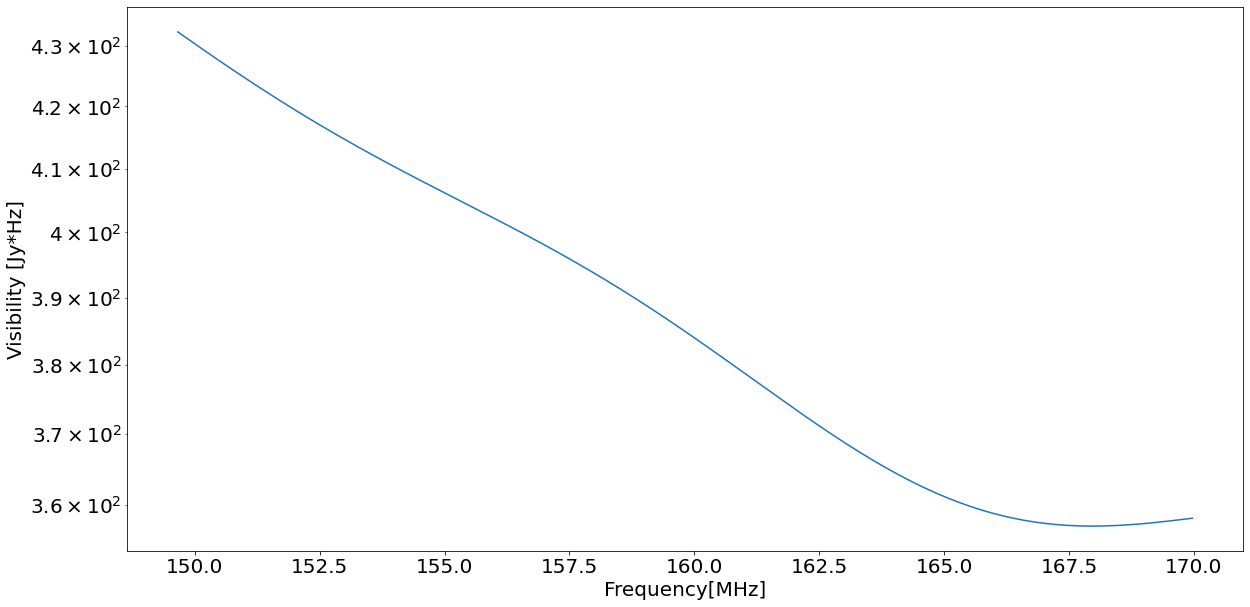

In [49]:
plt.plot(data.freqs[200:409]/1e6, avg_after[200:409], label='AVG AFTER')
plt.ylabel('Visibility [Jy*Hz]')
plt.xlabel('Frequency[MHz]')
plt.yscale('log')

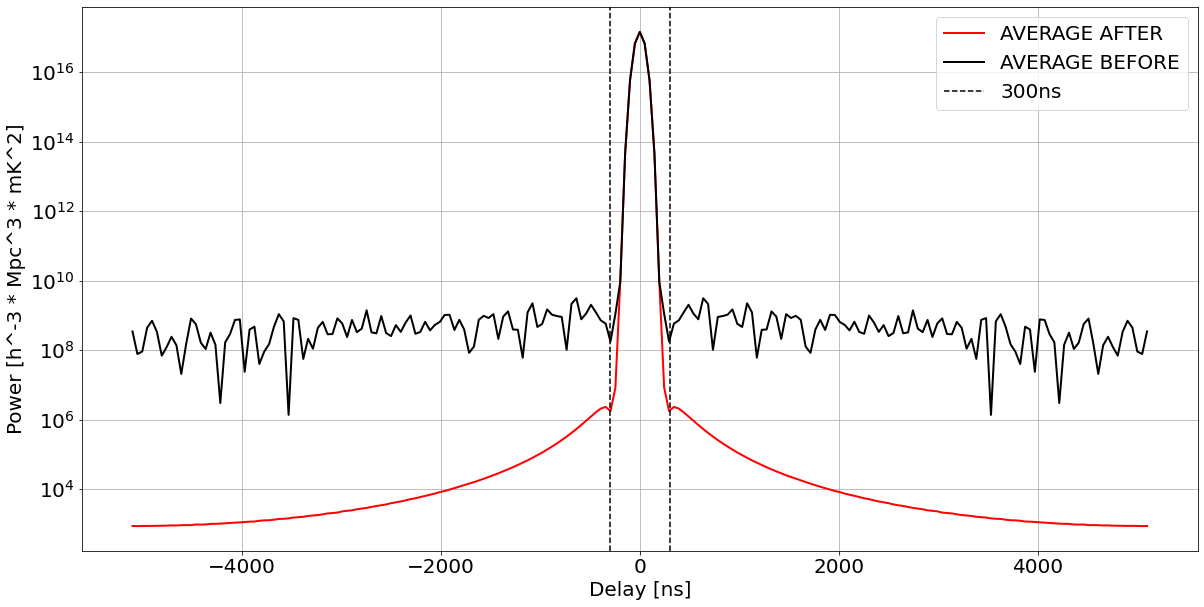

In [72]:
data.freqs = data.freqs[200:409]
avg_after = avg_after[200:409]
avg_before = avg_before[200:409]
bh = dspec.gen_window('bh',209)
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))

lambda_obs = 2      #150MHz ---> 2m
lambda_emit = 0.21      #0.21m 
z = (lambda_obs - lambda_emit)/lambda_emit  #z=8.5
X2Y = 540*(((1+z)/10)**(0.9))
B = data.freqs.max()-data.freqs.min()  
d = 14           #14m (diameter of dish)
theta = (1.22*(lambda_obs/d))**2
Omega = np.pi*theta**2
k_b = 1.38e-23  #J/K
Power_Transformation = ((X2Y)/(Omega*B))*(((2*k_b)/(lambda_obs**2))**-2)*(1e-52)


avg_after = fft(bh*avg_after)
avg_before = fft(bh*avg_before)

avg_after = (np.abs(avg_after)**2)*Power_Transformation
avg_before = (np.abs(avg_before)**2)*Power_Transformation


plt.plot(delay_blh*1e+9,(avg_after*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,(avg_before*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()